<div align='center'>
    <h1>Implementación Unet</h1>
</div>

---

Tutorial: [aquí](https://becominghuman.ai/implementing-unet-in-pytorch-8c7e05a121b4)

Este tipo de red neuronal esta principalmente compuesta de dos partes, un bloque de contracción (_**parte izquierda**_) y otro bloque de expansión (_**parte derecha**_). Posee la siguiente forma: <br><br>

<div align="center">
    <img src="./Ilustraciones/Unet.jpeg"/>
    <figcaption>Imagen UNET</figcaption>
</div>

<br><br>

<p style='text-align: justify;'> 
La parte izquierda es solo una simple <i><b>red convolucional</b></i>. En cada eslabón de esta parte de la red existen dos capas de convolución (3x3), cada una seguida de una función de activación Relu, y luego se aplica una capa maxpool (2x2) (flecha      roja en la imagen). Notar que la primera barra vertical en el lado izquierdo de la imagen no es una capa, sino que representa la entrada (imagen de entrada).</p>

<p style='text-align: justify;'>
 En la parte derecha de la red es donde suceden cosas interesantes. En esta sección también se usan dos capas de convolución de (3x3) apiladas juntas (secuencialmente) como el lado izquierdo, pero no se usa la función de activación de <i>ReLU</i> y no se usa una capa maxpool. En su lugar, se usa una capa de convolución transpuesta (2x2) (flecha verde en la imagen). Durante la ruta de expansión, tomaremos la  imagen (copia) del lado izquierdo y la combinaremos con la imagen de la derecha (flecha gris en la imagen). Recuerde que también se utilizan capas de convolución secuenciales de 3x3 en el lado derecho, por lo que la entrada para eso será la combinación de la imagen de la derecha y su capa anterior (la mitad del cuadro blanco y azul en el lado derecho de la imagen es la combinación). La capa de salida en el lado derecho se aplica una capa de convolución adicional (mapa de segmentación de salida).
</p>


## Importamos librerías

In [1]:
import torch
import torch.nn as nn

## Bloque de contracción

En primera instancia implementaremos una función llamada `dual_conv()` la cual se encargará de contener las capas convolucionales y de polling de izquierda de la red.

In [2]:
def dual_conv(in_channel, out_channel):
    
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3),
        nn.ReLU(inplace=True))
    
    return conv

En segundo lugar, implementamos una clase `Unet` la cual se encarga de contener la parte izquierda de la red. Llamaremos `dwn_conv_n` a las capas convolucionales de la primera parte de la red, debido a que en la imagen aparecen ilustradas como flechas que apuntan hacia abajo.

In [3]:
class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        self.dwn_conv_1 = dual_conv(1, 64)
        self.dwn_conv_2 = dual_conv(64 ,128)
        self.dwn_conv_3 = dual_conv(128 ,256)
        self.dwn_conv_4 = dual_conv(256 ,512)
        self.dwn_conv_5 = dual_conv(512 ,1024)
        self.maxpool    = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, input_img):
        
        x1 = self.dwn_conv_1(input_img)
        x2 = self.maxpool(x1)
        
        x3 = self.dwn_conv_2(x2)
        x4 = self.maxpool(x3)
        
        x5 = self.dwn_conv_3(x4)                                
        x6 = self.maxpool(x5)
        
        x7 = self.dwn_conv_4(x6)
        x8 = self.maxpool(x7)
        
        x9 = self.dwn_conv_5(x8)        

Con el código anterior la parte _**izquierda**_ de la red esta completa, ahora debemos codear la parde __*derecha*__.

## Bloque de expansión

<p style='text-align: justify;'>Para comenzar a implementar esta sección, debemos añadir las convoluciones transpuestas y las capas convolucionales de "subida" a nuestra red. Por otra parte, como vimos en la imagen de la arquitectura, las entradas de cada bloque de la parte derecha de Unet corresponden a una combinación entre las salidas de los bloques del lado izquierdo (flechas grises) y la salida de la capa anterior. Para combinar estas entradas debemos hacer un <i>resize</i> para que tengan las mismas dimensiones, por lo que implementaremos una función crop_image() con el fin de re-dimensionar las imagenes.</p>

In [4]:
def crop_tensor(target_tensor, tensor):
    
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    
    return tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]

In [5]:
class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Parte izquierda (bloque de contracción)
        self.dwn_conv_1 = dual_conv(1, 64)
        self.dwn_conv_2 = dual_conv(64 ,128)
        self.dwn_conv_3 = dual_conv(128 ,256)
        self.dwn_conv_4 = dual_conv(256 ,512)
        self.dwn_conv_5 = dual_conv(512 ,1024)
        self.maxpool    = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Parte derecha (bloque de expansión)
        self.trans_1 = nn.ConvTranspose2d(1024,512, kernel_size=2, stride= 2)
        self.up_conv_1 = dual_conv(1024,512)
        self.trans_2 = nn.ConvTranspose2d(512,256, kernel_size=2, stride= 2)
        self.up_conv_2 = dual_conv(512,256)
        self.trans_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride= 2)
        self.up_conv_3 = dual_conv(256,128)
        self.trans_4 = nn.ConvTranspose2d(128,64, kernel_size=2, stride= 2)
        self.up_conv_4 = dual_conv(128,64)

        #Capa de salida
        self.out = nn.Conv2d(64, 2, kernel_size=1)
        
        
    def forward(self, input_img):
        
        # Paso hacia adelante (lado izquierdo)
        x1 = self.dwn_conv_1(input_img)
        x2 = self.maxpool(x1)
        
        x3 = self.dwn_conv_2(x2)
        x4 = self.maxpool(x3)                               
        
        x5 = self.dwn_conv_3(x4)                                
        x6 = self.maxpool(x5)
        
        x7 = self.dwn_conv_4(x6)
        x8 = self.maxpool(x7)
        
        x9 = self.dwn_conv_5(x8)
        
        # Paso hacia adelante (lado derecho)
        x = self.trans_1(x9)
        y = crop_tensor(x, x7)
        x = self.up_conv_1(torch.cat([x,y], 1))
        
        x = self.trans_2(x)
        y = crop_tensor(x, x5)
        x = self.up_conv_2(torch.cat([x,y], 1))
        
        x = self.trans_3(x)
        y = crop_tensor(x, x3)
        x = self.up_conv_3(torch.cat([x,y], 1))
        
        x = self.trans_4(x)
        y = crop_tensor(x, x1)
        x = self.up_conv_4(torch.cat([x,y], 1))
        
        x = self.out(x)
        
        return x

### Probamos el modelo

In [39]:
import torchvision.transforms as tf
import matplotlib.pyplot as plt

In [40]:
torch.manual_seed(17) # Semilla fija

In [41]:
img = torch.rand((1, 1, 572, 572))
model = Unet()

Transformaciones

In [42]:
transform_1 = tf.Compose([
    tf.ToPILImage()
])

In [54]:
out= model(img); out=out*255

In [55]:
out = out.reshape((2, 388, 388))

In [56]:
out.size()

torch.Size([2, 388, 388])

In [57]:
out_PIL = transform_1(out)

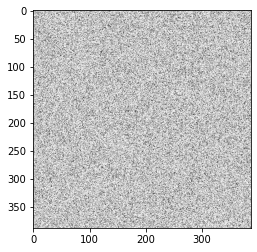

In [58]:
plt.imshow(out_PIL)
plt.show()